<a href="https://colab.research.google.com/github/yongbin02/AI/blob/main/10%EC%A3%BC%EC%B0%A8/UCI_HAR_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, GRU,
    Conv1D, MaxPooling1D, concatenate
)

In [3]:
def load_file(filepath):
    # 하나의 txt 파일을 읽어서 넘파이 배열로 반환
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [4]:
def load_group(filenames, prefix=''):
    # 여러 센서 파일을 읽어 3D 텐서로 결합
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)     # shape: (samples, timesteps, channels)
    return loaded

In [5]:
def load_dataset_group(group, prefix=''):
    # 특정 그룹(train/test)의 inertial signals 데이터 9개 불러오기
    filepath = prefix + group + '/Inertial Signals/'

    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']

    # X: 9개 센서 로드
    X = load_group(filenames, filepath)

    # y: 활동 레이블
    y = load_file(prefix + group + '/y_'+group+'.txt')

    return X, y

In [6]:
def load_dataset(prefix=''):

    base = '/content/drive/MyDrive/Colab Notebooks/AI/20251104/data/UCI HAR Dataset/'     # UCI HAR 기본 폴더

    # load all train
    trainX, trainy = load_dataset_group('train', base)

    # load all test
    testX, testy = load_dataset_group('test', base)

    # zero-offset class values (1~6 → 0~5)
    trainy = trainy - 1
    testy = testy - 1

    # one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print(trainX.shape, trainy.shape, trainy_one_hot.shape,
          testX.shape, testy.shape, testy_one_hot.shape)

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [8]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1511245515.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [9]:
scaler = StandardScaler()

# reshape → scale → reshape back (3D 유지)
trainX_2d = trainX.reshape(-1, trainX.shape[2])
testX_2d = testX.reshape(-1, testX.shape[2])

trainX_scaled = scaler.fit_transform(trainX_2d).reshape(trainX.shape)
testX_scaled = scaler.transform(testX_2d).reshape(testX.shape)

# 스케일링된 데이터로 교체
trainX = trainX_scaled
testX = testX_scaled

In [10]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy,
    test_size=0.2, random_state=100
)

X_train.shape, X_val.shape, y_train_one_hot.shape, y_val_one_hot.shape, y_train.shape, y_val.shape


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [12]:
# 모델 입력 변수 설정
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [13]:
# GRU 기반 모델 구조
inputs = Input(shape=(n_timesteps, n_features))

# 첫 번째 GRU Layer
gru1 = GRU(128, return_sequences=True)(inputs)
gru1 = Dropout(0.3)(gru1)

# 두 번째 GRU Layer
gru2 = GRU(64, return_sequences=False)(gru1)
gru2 = Dropout(0.3)(gru2)

# Dense Layer
dense = Dense(512, activation='relu')(gru2)
dense = Dropout(0.5)(dense)

# Output Layer
outputs = Dense(n_outputs, activation='softmax')(dense)

# MODEL
gru_model = Model(inputs, outputs)

gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

gru_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,982 (496.02 KB)

 Trainable params: 126,982 (496.02 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = gru_model.fit(
    X_train, y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5427 - loss: 1.1297 - val_accuracy: 0.8862 - val_loss: 0.3260
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9040 - loss: 0.2692 - val_accuracy: 0.9372 - val_loss: 0.1257
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9350 - loss: 0.1637 - val_accuracy: 0.9406 - val_loss: 0.1171
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9459 - loss: 0.1317 - val_accuracy: 0.9593 - val_loss: 0.1279
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9572 - loss: 0.1140 - val_accuracy: 0.9525 - val_loss: 0.1308
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9464 - loss: 0.1235 - val_accuracy: 0.9559 - val_loss: 0.1531
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9504 - loss: 0.1304 - val_accuracy: 0.9593 - val_loss: 0.1076
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9526 - loss: 0.1155 - val_acc

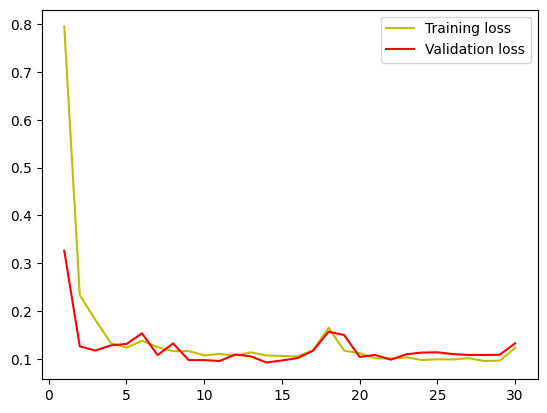

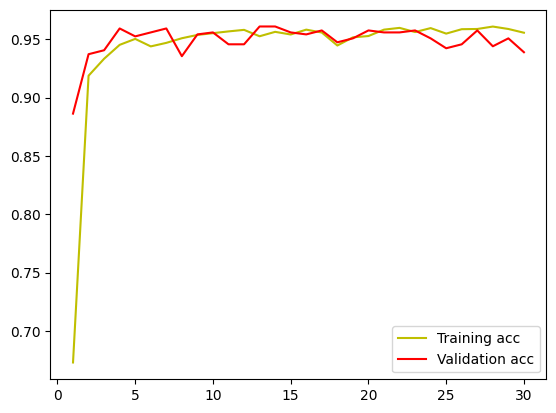

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
[[487   1   8   0   0   0]
 [  0 446  23   2   0   0]
 [  0  22 398   0   0   0]
 [  0   1   0 419  67   4]
 [  0   1   0 118 413   0]
 [  0   0   0   0   0 537]]
0.9161859518154055
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       496
           1       0.95      0.95      0.95       471
           2       0.93      0.95      0.94       420
           3       0.78      0.85      0.81       491
           4       0.86      0.78      0.82       532
           5       0.99      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



<Axes: >

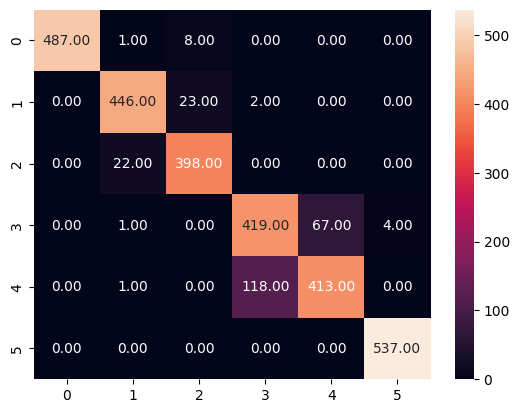

In [16]:
pred = gru_model.predict(testX)

pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')